In [1]:
##Ben Pelto June 2019
###using this script to plot the thickness difference for an individual glacier between OGGM linear gradient and 
###a user defined mass balance gradient

# Python imports
import os
import pandas as pd
import salem
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

In [2]:
num = 6 #num determines which gdir and gradient to use, refer to list below to select desired site

# min to max gradients
# grad = [5.8, 9.8, 5.9, 7.95, 6.2, 5.3, 5.8] #mm we m-1
#data points gradients
grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1 

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48]
products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']

In [3]:
WORKING_DIR = utils.get_temp_dir('ice_thickness')
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

2019-09-26 13:10:53: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [4]:
# dx = 100 
# cfg.PARAMS['use_rgi_area'] = False
cfg.PARAMS['border'] = 10

In [5]:
#testing effect of larger grid cell size
# cfg.PARAMS['grid_dx_method'] = 'fixed'
# cfg.PARAMS['fixed_dx'] = dx

In [6]:
# Get the RGI glaciers for the run.
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']

In [7]:
rgidf = utils.get_rgi_glacier_entities(rgi_list) 
gdirs = workflow.init_glacier_regions(rgidf)
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
# gdir = gdirs[0]
# tasks.init_present_time_glacier(gdirs) 

2019-09-26 13:10:54: oggm.workflow: Execute entity task define_glacier_region on 7 glaciers
2019-09-26 13:10:54: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers()

In [8]:
shapefile = ['2017/Kokanee_17_final_WGS84_clip.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']
DF_Final=pd.DataFrame({'Glacier':[],'lat':[],'long':[],'depth':[],'x':[],'y':[]})
##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now
for i in range(7):
    
    #df = df[i]
    df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[i])
    coords = np.array([p.xy for p in df.geometry]).squeeze()
    df['lon'] = coords[:, 0]
    df['lat'] = coords[:, 1]
    # df['lon'] = df[4]
    # df['lat'] = df[5]
    df = df[['lon', 'lat', 'depth']]
    # Convert the longitudes and latitudes to the glacier map projection:

    xx, yy = salem.transform_proj(salem.wgs84, gdirs[i].grid.proj, df['lon'].values, df['lat'].values)
    df['x'] = xx
    df['y'] = yy
    DF_Final=DF_Final.append({'Glacier':glacier[i],'lat':df['lat'],'long':df['lon'],'depth':df['depth'],'x':df['x'],'y':df['y']}, ignore_index=True)

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


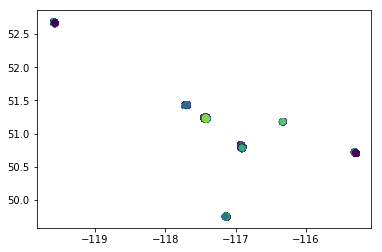

In [9]:
#plot these data
i=3
for i in range(7):
    geom = gdirs[i].read_shapefile('outlines')
#f, ax = plt.subplots()
    df=DF_Final[DF_Final.index==i]
    plt.scatter(x=df.long[i], y=df.lat[i], c=df.depth[i], cmap='viridis')#, s=10)#, ax=ax); #cmap='Blues',
#     geom.plot(ax=ax, facecolor='none', edgecolor='k');

In [10]:
import geopandas as gpd
shape=gpd.read_file("/home/pelto/GIS/outlines/ice_thick_glaciers.shp")
shape

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.00147,G242863E49749N,20049999,20069999,-117.137,49.7490,2,3,1.801,2258,...,33,1738,0.0,0.0,0.0,0.0,0.0,9,None,"POLYGON ((-117.151037 49.75008800000006, -117...."
1,RGI60-02.01857,G244699E50711N,20049999,20069999,-115.301,50.7108,2,3,2.585,2482,...,116,2839,0.0,0.0,0.0,0.0,0.0,9,None,"POLYGON ((-115.312561 50.71309000000008, -115...."
2,RGI60-02.03411,G243670E51177N,20049999,20069999,-116.330,51.1770,2,3,0.872,2390,...,69,1181,0.0,0.0,0.0,0.0,0.0,9,None,"POLYGON ((-116.323606 51.18003200000004, -116...."
3,RGI60-02.07780,G240419E52671N,20049999,20069999,-119.581,52.6705,2,3,6.490,1717,...,356,4150,0.0,0.0,0.0,0.0,0.0,9,None,POLYGON ((-119.5952742098528 52.68276424606576...
4,RGI60-02.04264,G242290E51429N,20049999,20069999,-117.710,51.4292,2,3,4.425,1979,...,14,2540,0.0,0.0,0.0,0.0,0.0,9,None,POLYGON ((-117.7251266266143 51.42201803589593...
5,RGI60-02.03688,G242566E51237N,20049999,20069999,-117.434,51.2370,2,3,5.944,1992,...,297,3958,0.0,0.0,0.0,0.0,0.0,9,None,POLYGON ((-117.4483424112458 51.22971735581437...
6,RGI60-02.02171,G243070E50807N,20049999,20069999,-116.930,50.8069,2,3,16.898,1855,...,16,8626,NaN,NaN,NaN,NaN,NaN,9,None,POLYGON ((-116.9046869317124 50.78361803038761...


In [24]:
# shape.sort(['RGIId'], ascending)
shape['order'] = [0,1,2,3,4,5,6]
# shape.sort_values('RGIId', inplace=True)
shape

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,order
0,RGI60-02.00147,G242863E49749N,20049999,20069999,-117.137,49.7490,2,3,1.801,2258,...,1738,0.0,0.0,0.0,0.0,0.0,9,None,"POLYGON ((-117.151037 49.75008800000006, -117....",0
1,RGI60-02.01857,G244699E50711N,20049999,20069999,-115.301,50.7108,2,3,2.585,2482,...,2839,0.0,0.0,0.0,0.0,0.0,9,None,"POLYGON ((-115.312561 50.71309000000008, -115....",1
6,RGI60-02.02171,G243070E50807N,20049999,20069999,-116.930,50.8069,2,3,16.898,1855,...,8626,NaN,NaN,NaN,NaN,NaN,9,None,POLYGON ((-116.9046869317124 50.78361803038761...,2
2,RGI60-02.03411,G243670E51177N,20049999,20069999,-116.330,51.1770,2,3,0.872,2390,...,1181,0.0,0.0,0.0,0.0,0.0,9,None,"POLYGON ((-116.323606 51.18003200000004, -116....",3
5,RGI60-02.03688,G242566E51237N,20049999,20069999,-117.434,51.2370,2,3,5.944,1992,...,3958,0.0,0.0,0.0,0.0,0.0,9,None,POLYGON ((-117.4483424112458 51.22971735581437...,4
4,RGI60-02.04264,G242290E51429N,20049999,20069999,-117.710,51.4292,2,3,4.425,1979,...,2540,0.0,0.0,0.0,0.0,0.0,9,None,POLYGON ((-117.7251266266143 51.42201803589593...,5
3,RGI60-02.07780,G240419E52671N,20049999,20069999,-119.581,52.6705,2,3,6.490,1717,...,4150,0.0,0.0,0.0,0.0,0.0,9,None,POLYGON ((-119.5952742098528 52.68276424606576...,6


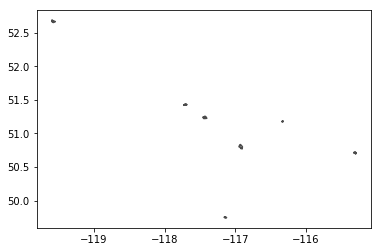

In [25]:
for i in np.arange(0,7,1):
    x,y=shape['geometry'][i].exterior.xy
    plt.plot(x,y,color='k',alpha=0.7)
plt.show()

In [26]:
GIDX=shape[shape.order==i].index[0]
GIDX

3

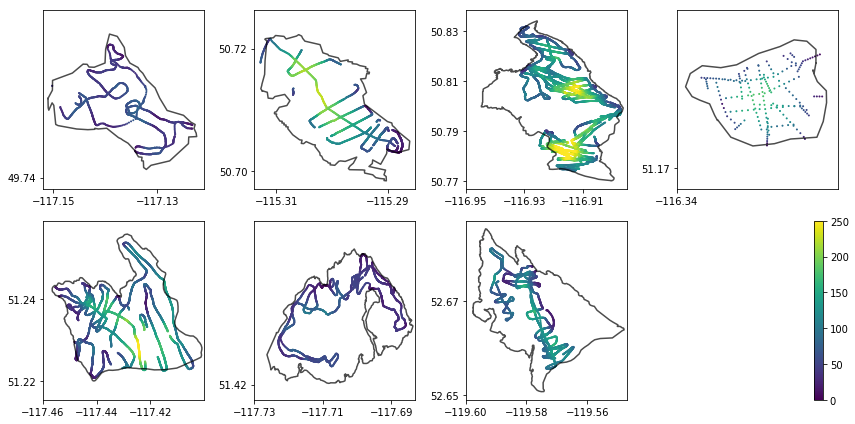

In [91]:
f, axarr = plt.subplots(2, 4, sharey=False, sharex=False, figsize=(12, 6))
j, k = 0, 0

shape.sort_values('CenLat', inplace=True)

for i in range(7):
#     geom = gdirs[i].read_shapefile('outlines')
       
    df=DF_Final[DF_Final.index==i]
    im = axarr[j, k].scatter(df.long[i], df.lat[i], c=df.depth[i], cmap='viridis', vmax=250, vmin=0, s=1.)#, s=10)#, ax=ax); #cmap='Blues',
#     
#     axarr[j, k].set_title(glacier[i])
       
    GIDX=shape[shape.order==i].index[0]
    x,y=shape[shape.order==i]['geometry'][GIDX].exterior.xy
    axarr[j, k].plot(x,y,color='k',alpha=0.7)
    
    ymin = np.round(min(y),3) -0.001
    ymax = np.round(max(y),3) + 0.001
    xmin = np.round(min(x),3) -0.001
    xmax = np.round(max(x),3) + 0.001
#     axarr[j, k].set_ylim(ymin, ymax)
    axarr[j, k].set_xlim(xmin, xmax )
    
    axarr[j, k].set_xticks(np.round(np.arange(xmin, xmax, 0.02),2))
    axarr[j, k].ticklabel_format(useOffset=False)
    axarr[1, 3].axis('off')
    axarr[j, k].set_yticks(np.round(np.arange(ymin, ymax, 0.02),2))
    
    
#     axarr[0, 2].plot.colorbar()
    
#     axarr[j, k].set_xticks

    k += 1

    if i == 3: #changed to 2, 1 worked for 2x2 panel plot
        j += 1
        k = 0
     
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#     axins = inset_axes(axarr[1, 3],
#                    width="10%",  # width = 5% of parent_bbox width
#                    height="100%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(0, 0., 1, 1),
#                    bbox_transform=axarr[1, 3].transAxes,
#                    borderpad=0,
#                    )      
        
plt.colorbar(im, pad=0.00) #, cax=axins)    

plt.tight_layout()
plt.savefig(products_dir + 'ice_thickness_all.png', dpi=300) 

# ymin = df.lat[i].min() -0.005
# ymax = df.lat[i].max() + 0.005
# xmin = np.round(df.long[i].min(),3) -0.001
# xmax = np.round(df.long[i].max(),3) + 0.001
# axarr[j, k].set_ylim(ymin, ymax)
# axarr[j, k].set_xlim(xmin, xmax )

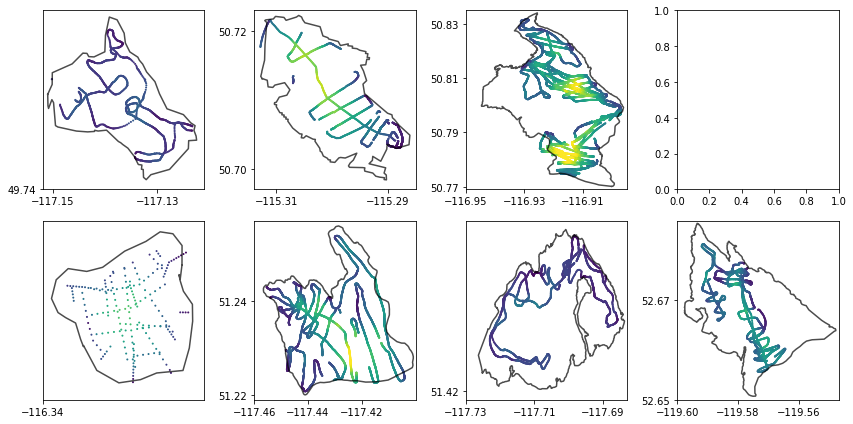

In [58]:
f, axarr = plt.subplots(2, 4, sharey=False, sharex=False, figsize=(12, 6))
j, k = 0, 0

shape.sort_values('CenLat', inplace=True)

for i in range(7):
#     geom = gdirs[i].read_shapefile('outlines')
       
    df=DF_Final[DF_Final.index==i]
    axarr[j, k].scatter(df.long[i], df.lat[i], c=df.depth[i], cmap='viridis', vmax=250, vmin=0, s=1.)#, s=10)#, ax=ax); #cmap='Blues',
#     
#     axarr[j, k].set_title(glacier[i])
       
    GIDX=shape[shape.order==i].index[0]
    x,y=shape[shape.order==i]['geometry'][GIDX].exterior.xy
    axarr[j, k].plot(x,y,color='k',alpha=0.7)
    
    ymin = np.round(min(y),3) -0.001
    ymax = np.round(max(y),3) + 0.001
    xmin = np.round(min(x),3) -0.001
    xmax = np.round(max(x),3) + 0.001
    axarr[j, k].set_ylim(ymin, ymax)
    axarr[j, k].set_xlim(xmin, xmax )
    
    axarr[j, k].set_xticks(np.round(np.arange(xmin, xmax, 0.02),2))
    axarr[j, k].ticklabel_format(useOffset=False)
#     axarr[0, 3].axis('off')
    axarr[j, k].set_yticks(np.round(np.arange(ymin, ymax, 0.02),2))
    
#     axarr[0, 2].plot.colorbar()
    
#     axarr[j, k].set_xticks

    k += 1

    if i == 2: #changed to 2, 1 worked for 2x2 panel plot
        j += 1
        k = 0
        
plt.tight_layout()
plt.savefig(products_dir + 'ice_thickness_all.png', dpi=300) 

# ymin = df.lat[i].min() -0.005
# ymax = df.lat[i].max() + 0.005
# xmin = np.round(df.long[i].min(),3) -0.001
# xmax = np.round(df.long[i].max(),3) + 0.001
# axarr[j, k].set_ylim(ymin, ymax)
# axarr[j, k].set_xlim(xmin, xmax )